<a href="https://colab.research.google.com/github/DinhNgocVan/NLP_XLNet_Final_Project/blob/main/CoLA_dataset_XLNet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This is the implementation of me to XLNet paper. The summary of XLNet is in the report, so in here just show implementation part in details. 
I use Huggingface library for implementing transfomers and use it to get the model I need.

# Data

I used my drive to save all of the dataset. I use **Corpus of Linguistic Acceptability (CoLA)** from Kaggle(link: https://nyu-mll.github.io/CoLA/) to show up and then extract, and move them to my drive.
        
Another way to get the dataset is download it to local computer and upload it with `uploaded = files.upload()`. But drive is more convenient to me.

The Corpus of Linguistic Acceptability (CoLA) consists of 10657 sentences from 23 linguistics publications, expertly annotated for acceptability (grammaticality) by their original authors. The public version contains 9594 sentences belonging to training and development sets, and excludes 1063 sentences belonging to a held out test set." to show up and then extract, and move them to my drive.

Another way to get the dataset is download it to local computer and upload it with `uploaded = files.upload()`. But drive is more convenient to me.


In [1]:
#Connect with drive folder and determine the important path to go with.
from google.colab import drive
drive.mount('/content/drive')
folder_path='/content/drive/My Drive/xlnett'
data_path='/content/drive/My Drive/xlnett/Data'

Mounted at /content/drive


# Install and Import

I install the libraries, especially transfomers one I need. 

In [ ]:
!pip install pytorch-transformers
!pip install transformers

     |████████████████████████████████| 176 kB 7.9 MB/s 
     |████████████████████████████████| 131 kB 64.2 MB/s 
     |████████████████████████████████| 1.2 MB 60.8 MB/s 
     |████████████████████████████████| 895 kB 65.6 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 8.5 MB 51.6 MB/s 
     |████████████████████████████████| 138 kB 68.1 MB/s 
     |████████████████████████████████| 127 kB 69.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.4 MB 7.3 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 

I import all the libraries I need down there.
The most important library are **XLNetTokenizer** and **XLNetSequenceClassification** to construct the tokenizer and model later on.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

import torch.optim as optim

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
import seaborn as sns
from datetime import datetime

% matplotlib inline

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preprocessing and prepare data
Use the raw data version because I use the XLNet tokenizer to break the text down into tokens and chunks that the model will recognize.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/xlnett/Data/in_domain_train.tsv", delimiter='\t', delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

Add special tokens which are "[SEP]" and "[CLS]" to the end for each sentence for XLNet to work properly.
The token pattern: 


```
Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]
```



In [ ]:
sentences = df.sentence.values

Create label list and see some of its value

In [ ]:
labels = df.label.values
labels

array([1, 1, 1, ..., 1, 1, 1])

Then I import the XLNet tokenizer, used to convert the text into tokens..

In [ ]:
#Using XLNetTokenizer to tokenize to senteces
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
#Tokenize a sentence to words
tokenize = [tokenizer.tokenize(sent) for sent in sentences]

Check the first sentence see what I get after tokenize.

In [ ]:
tokenize[0]

['▁our',
 '▁friends',
 '▁won',
 "'",
 't',
 '▁buy',
 '▁this',
 '▁analysis',
 ',',
 '▁let',
 '▁alone',
 '▁the',
 '▁next',
 '▁one',
 '▁we',
 '▁propose',
 '.',
 '[',
 's',
 'ep',
 ']',
 '▁[',
 'cl',
 's',
 ']']

XLNet requires specifically formatted inputs. For each tokenized input sentence, need to create:


1.   input ids: a sequence of integers identifying each input token to its index number in the XLNet tokenizer vocabulary
2.   segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
3. attention mask: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens
4. labels: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

I just use two require are **input_ids and labels.**

About **pad_sequences**

To "pad" the inputs means that if a sentence is shorter than the maximum sentence length, we will add 0s to the end of the sequence until it is the maximum sentence length.
If a sentence is longer than the maximum sentence length, then we truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) pad_sequences handles the truncating and padding of Python lists.

In [ ]:
# Set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary then pad input tokens


In [ ]:
#convert token to id
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenize]
input_ids = pad_sequences(input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long", truncating="post", padding="post")
input_ids

array([[  120,  1003,   282, ...,     0,     0,     0],
       [   65,    70, 19614, ...,     0,     0,     0],
       [   65,    70, 19614, ...,     0,     0,     0],
       ...,
       [   36,    27,   955, ...,     0,     0,     0],
       [   17,   150,    54, ...,     0,     0,     0],
       [  113,    71,   190, ...,     0,     0,     0]])

In [ ]:
#train_test_split to split data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                                                    test_size=0.2)

Convert all of our data into torch tensors, the model that I used required that datatype.


In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

I define some hyperparameters I need after with values is the recommendation of the paper

In [ ]:
#HYPERPARAMETERS
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

Create an iterator of data with torch DataLoader. This helps save on memory during training.

In [ ]:
train_dataset = TensorDataset(train_inputs, train_labels)
valid_dataset = TensorDataset(validation_inputs, validation_labels)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Print number of batches in each split.
print('Created `torchtext_train_dataloader` with %d batches!'%len(train_dataloader))
print('Created `torchtext_valid_dataloader` with %d batches!'%len(valid_dataloader))

Created `torchtext_train_dataloader` with 214 batches!
Created `torchtext_valid_dataloader` with 54 batches!


# Train Model
I use the “xlnet-base-uncased” version of XLNet, which is the smaller model than the “xlnet-large-uncased”. The model I used have 12-layer, 768-hidden, 12-heads.
For sentiment analysis task, first I have modify the pre-trained model to give outputs for classification then continue training the model on the dataset.
With another task, Huggingface transformers libraries for XLNet have many differences for tasks. 

Load XLNetForSequenceClassification. This is the normal XLNet model with an added single linear layer on top for classification use as a sentence classifier here. 

In [ ]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

Optimizers define how the weights of the neural network are to be updated.
I use AdamW optimizer which yields better training loss and that the models generalize much better than models trained with Adam. 








In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

Training loop and validation loop are below. There are some details of those.

1.   Training Mode:  Set by model.train(), it tells the model is training. So layers like dropout etc. which behave differently while training and testing can behave accordingly.
2.   Evaluation Mode:  Set by model.eval(), it tells the model is testing.

Training steps in traning loop: 
- Tell the model to compute gradients by setting the model in train mode
- Unpack data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
- Forward pass (feed input data through the network)
- Calculate the loss
- Perform a backward pass using loss.backward() to calculate the gradients
- Take optimizer step using optimizer.step() to update the weights
- Track variables for monitoring progress

Evaluation steps in evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack the data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on validation data and track variables for monitoring progress.

In [ ]:
#Calculate the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# initialize running values
train_loss_set = []

current_time = datetime.now()

for epoch in range(NUM_EPOCHS):
  #Training
  model.train()
  # Tracking variables
  running_loss = 0
  number_training_examples = 0.0
  number_training_steps = 0.0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs 
    input_ids_, labels_ = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(input_ids_, token_type_ids=None, labels=labels_)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()
    
    # Update tracking variables
    running_loss += loss.item()
    number_training_examples += input_ids_.size(0)
    number_training_steps += 1
  train_loss = running_loss/number_training_steps
       
  # Validation
  model.eval()

  # Tracking variables 
  eval_loss = 0
  eval_accuracy = 0
  number_eval_steps = 0
  number_eval_examples = 0

  # Evaluate data for one epoch
  for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    input_ids_, labels_ = batch
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(input_ids_, token_type_ids=None)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels_.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    number_eval_steps += 1
  accuracy = eval_accuracy/number_eval_steps
  # print progress
  print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Accuracy: {:.4f}'
                      .format(epoch+1, NUM_EPOCHS, 
                              train_loss, accuracy))
  
print("Total time ", datetime.now() - current_time)

Epoch [1/4], Train Loss: 0.6225, Validation Accuracy: 0.7105
Epoch [2/4], Train Loss: 0.6155, Validation Accuracy: 0.7105
Epoch [3/4], Train Loss: 0.6156, Validation Accuracy: 0.7079
Epoch [4/4], Train Loss: 0.5999, Validation Accuracy: 0.7277
Total time  0:14:13.283901


Visualize the training loss

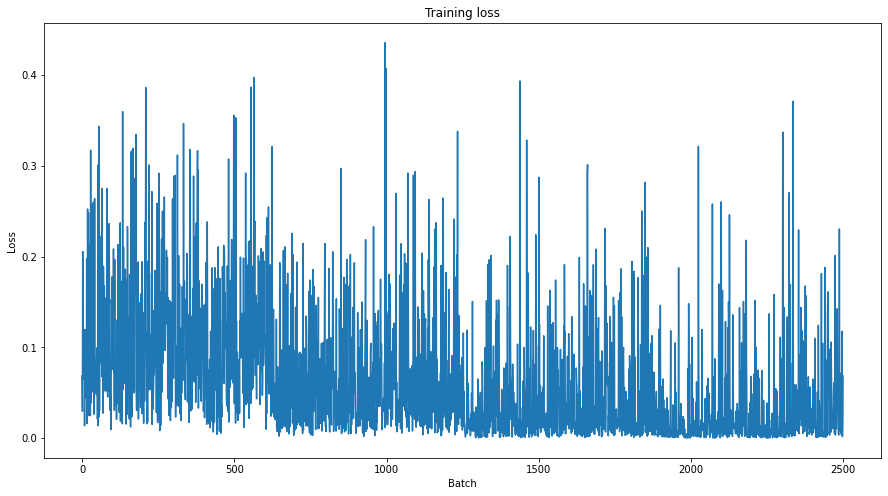

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Test the model and get its accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      input_ids_, labels_ = batch
      # Forward pass
      outputs = model(input_ids_, token_type_ids=None)
      logits = outputs[0]
      prediction = torch.argmax(logits, 1)
      total += labels_.size(0)
      correct+=(prediction==labels_).sum().item()
print('Test Accuracy on validation dataset is: {} %'.format(100 * correct / total))

Test Accuracy on validation dataset is: 72.76446522501462 %
